In [1]:
import matplotlib as plt
plt.rcParams["figure.autolayout"] = True # to for tight_layout()
import pymc as pm
import pytensor as pt
import numpy as np

# Modeling constraints with Dirac likelihood

In the model below we use tensor operations to produce boolean random variables modeling the constraints in the original problem. Furthermore, we use Dirac Delta distributions as likelihoods to give likelihood 1 to the case where a constraint holds and 0 otherwise.

In [3]:
with pm.Model() as model_dirac:
    num_vars = 5

    x = pm.DiscreteUniform('x',0,125,shape=num_vars)

    for i in range(num_vars-1):
        pm.DiracDelta(f'obs{i}', pt.tensor.le(x[i], x[i+1]), observed=True)

    pm.DiracDelta('obs_median_1', pt.tensor.eq(x[2], 30), observed=True)

    pm.DiracDelta(f'obs_sum', pt.tensor.eq(x[0] + x[1] + x[2] + x[3] + x[4], 38*5), observed=True)

    # covariance matrix of proposal dist (MultivariateNormal)
    S = np.zeros((num_vars,num_vars), np.int64)
    np.fill_diagonal(S,100)

    # config metropolis
    step = pm.Metropolis(
        S=S, # set new proposal dist
        tune_interval=1000 # incrase steps between samples?
    )

    trace = pm.sample(
        draws=int(1e5),
        tune=1000, # a lot of tunning steps
        chains=2,
        step = step, # set MH with modified proposal
        initvals={'x': [0,30,30,58,72]} # we must a satisfying initial state, otherwise it does not work...
    ) 

Multiprocess sampling (2 chains in 4 jobs)
Metropolis: [x]


Sampling 2 chains for 1_000 tune and 100_000 draw iterations (2_000 + 200_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


## Results

First, we note that MH requires to provide a satisfying sample otherwise it cannot even start. Furthermore, we observe that it cannot find any other samples. The proposal distribution is a multivariate Gaussian. We use a larger variance for each variable and higher tunning steps to increase exploration.

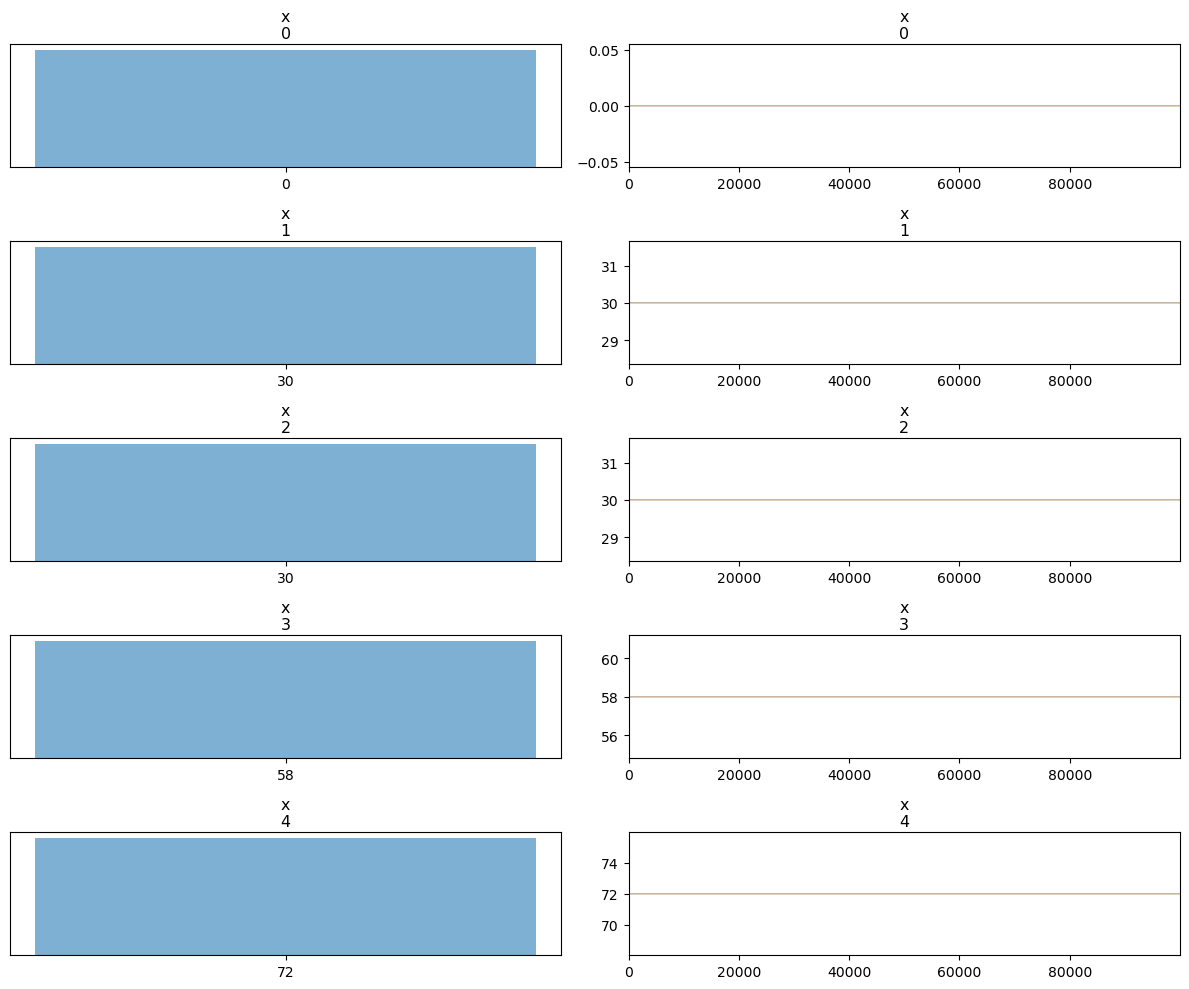

In [4]:
pm.plot_trace(trace, var_names=['x'] , combined=False, compact=False);

# Modeling constraints with Normal Likelihood

Here we use a soft-constrain as likelihood. This model is technically not equivalent to our original model. However, the hypothesis is that this likelihood may help the algorithm find the areas with higher density. The reason is that the normal distribution has no exact 0 density far from the mean.

We model the constrains by setting the Boolean operation on random variables as the mean of a Normal likelihood. The observation is set to True (for inequalities) and the required value for equalities.

In [8]:
with pm.Model() as model_approx_normal:
    num_vars = 5
    precision = 0.01

    x = pm.DiscreteUniform('x',0,125,shape=num_vars)

    for i in range(num_vars-1):
        c = pm.Deterministic(f'x{i} < x{i+1}', pt.tensor.le(x[i],x[i+1]))
        pm.Normal(f'obs{i}', mu=c, sigma=precision, observed=True)

    pm.Normal('obs_median_1', mu=x[2], sigma=precision, observed=30)

    sum_vars = pm.Deterministic('sum_vars',x[0] + x[1] + x[2] + x[3] + x[4])

    pm.Normal(f'obs_sum', mu=sum_vars, sigma=precision, observed=38*5)

    # covariance matrix of proposal dist (MultivariateNormal)
    S = np.zeros((num_vars,num_vars), np.int64)
    np.fill_diagonal(S,100)

    # config metropolis
    step = pm.Metropolis(
        S=S, # set new proposal dist
        tune_interval=1000 # incrase steps between samples?
    )

    trace2 = pm.sample(
        draws=int(1e5),
        tune=1000, # a lot of tunning steps
        chains=2,
        step = step#, # set MH with modified proposal
        # initvals={'x': [0,30,30,58,72]} # we do not need this in this case
    ) 

Multiprocess sampling (2 chains in 4 jobs)


Metropolis: [x]


/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/pymc/step_methods/metropolis.py:285: RuntimeWarning: overflow encountered in exp
  "accept": np.mean(np.exp(self.accept_rate_iter)),


Sampling 2 chains for 1_000 tune and 100_000 draw iterations (2_000 + 200_000 draws total) took 26 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


## Results

Here the results are also very poor. We set the proposal distribution as before to encourage exploration. With model without providing an initial state, it can only find 2 different samples. However, one of them does not really satisfy the constraints. If we provide the same initial state as above, then it finds only one sample.

/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("You

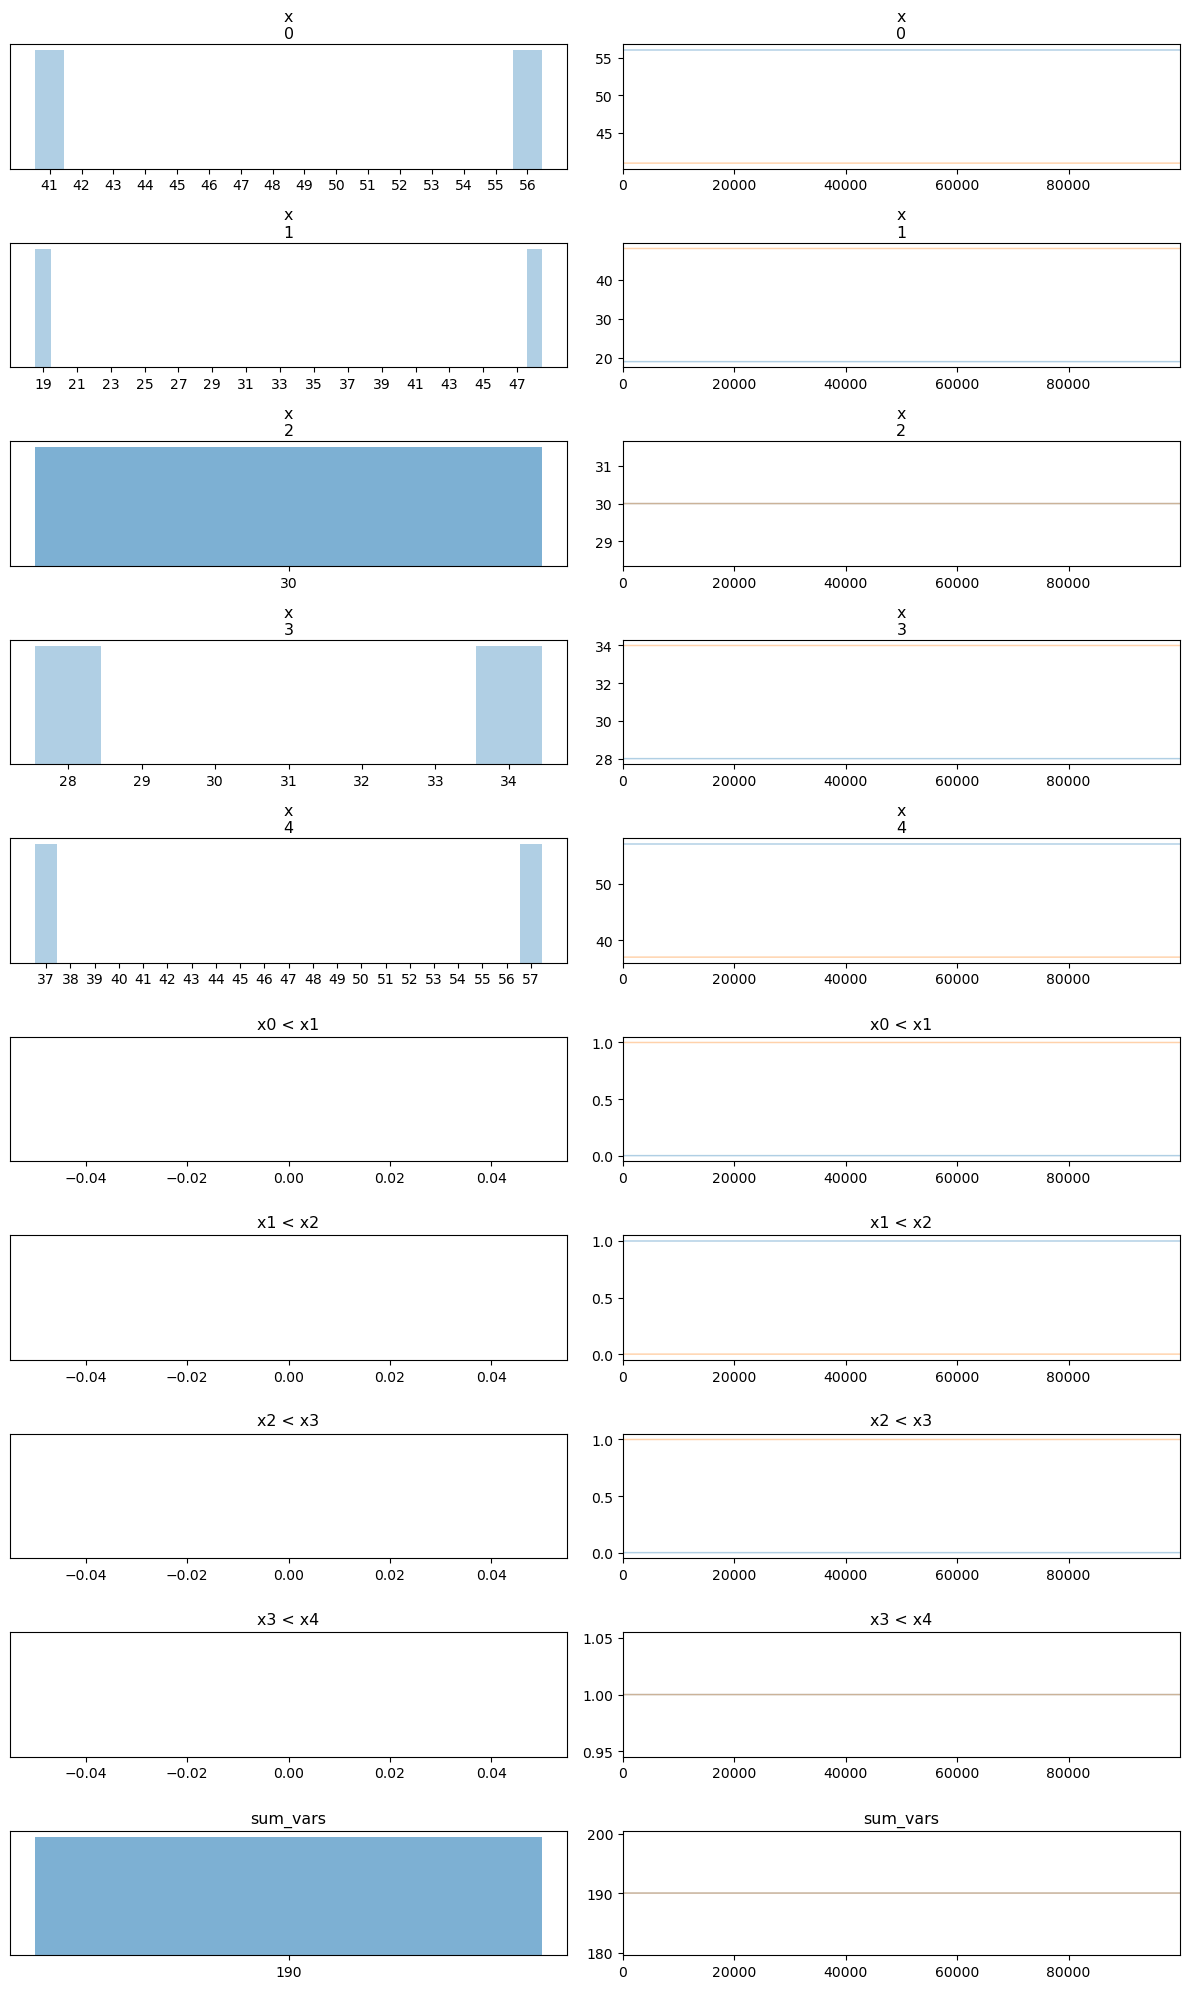

In [9]:
pm.plot_trace(trace2, compact=False);

In [10]:
np.unique(trace2.posterior.x, axis=1)

array([[[56, 19, 30, 28, 57]],

       [[41, 48, 30, 34, 37]]])

# Modeling constraints with Direc Likelihood and Poisson Proposal

Here we try the same as in the first model, but we use a Poisson proposal distribution. The hypothesis is that a discrete proposal distribution may make it more likely to meet the hard-constraints imposed by the Dirac Delta liklihood.

In [14]:
# now we try with a Poisson proposal
with pm.Model() as model_dirac_poisson:
    num_vars = 5

    x = pm.DiscreteUniform('x',0,125,shape=num_vars)

    for i in range(num_vars-1):
        c = pm.Deterministic(f'x{i} < x{i+1}', pt.tensor.le(x[i],x[i+1]))
        pm.DiracDelta(f'obs{i}', c, observed=True)

    pm.DiracDelta('obs_median_1', pt.tensor.eq(x[2], 30), observed=True)

    pm.DiracDelta(f'obs_sum', pt.tensor.eq(x[0] + x[1] + x[2] + x[3] + x[4], 38*5), observed=True)

    # values for the rate parameter  for each variable of a vector of Poisson distributions
    S = np.repeat(20,num_vars)

    # config metropolis
    step = pm.Metropolis(
        proposal_dist = pm.PoissonProposal,
        S=S, # set new proposal dist
        tune_interval=10_000 # increase steps between samples?
    )

    trace3 = pm.sample(
        draws=int(10_000),
        tune=1000, # a lot of tunning steps
        chains=2,
        progressbar=False,
        step = step, # set MH with modified proposal
        initvals={'x': [0,30,30,58,72]} # we must a satisfying initial state, otherwise it does not work...
    ) 

Multiprocess sampling (2 chains in 4 jobs)


Metropolis: [x]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 3 seconds.


We recommend running at least 4 chains for robust computation of convergence diagnostics


## Results

As before, it requires providing an initial state, otherwise I cannot start the sampling. Also as before, it finds only one sample (the one provided as initial state). So, the Poisson proposal distribution does not seem to help.

/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/home/pardo/programs/miniconda3/envs/prpro-2024/lib/python3.11/site-packages/arviz/stats/density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


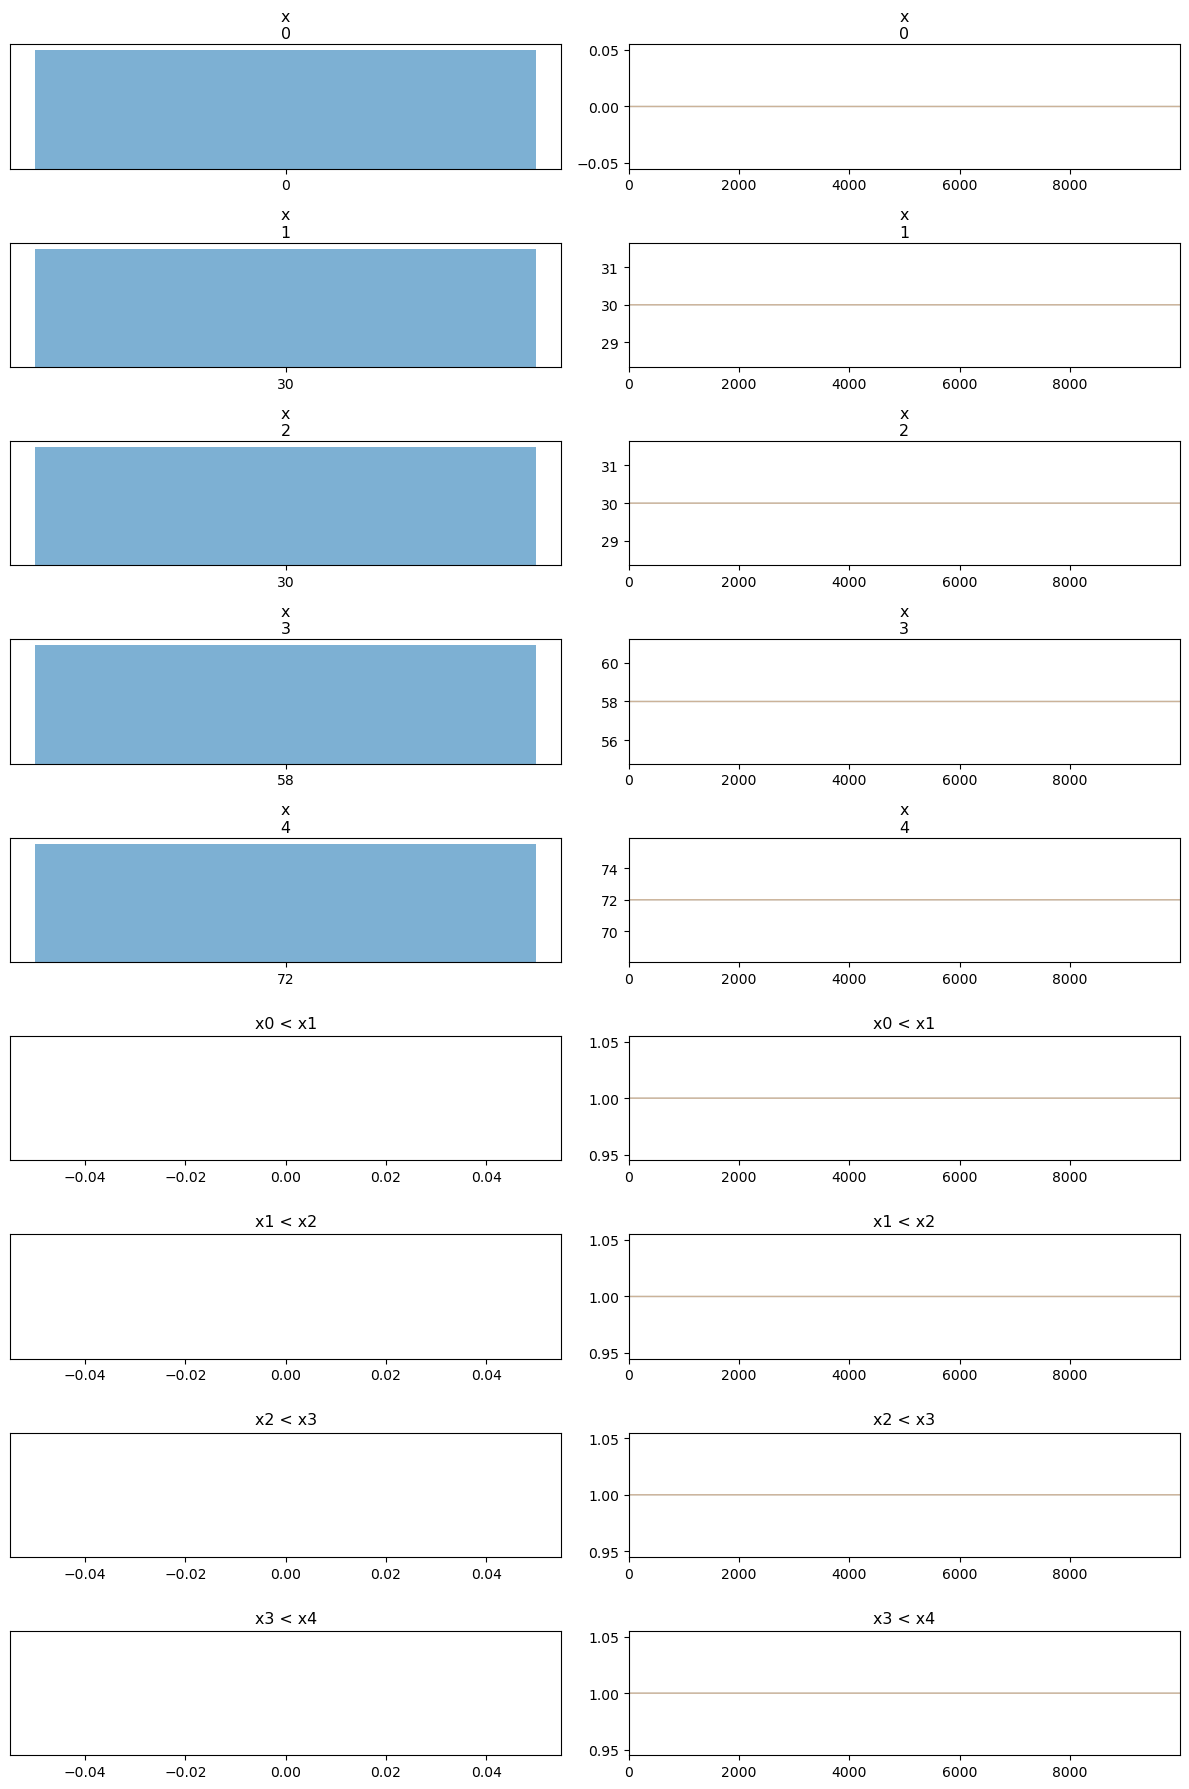

In [15]:
pm.plot_trace(trace3, compact=False);